In [1]:
import torch
import pandas as pd
import ltn
import numpy as np

from sklearn.model_selection import train_test_split

## Data Preparation

In [2]:
s_data = pd.read_csv('src\data\Stud_E-mobility_data_staticLimit.csv')

In [3]:
s_data = s_data[['_time','GARAGE_EXTERNAL_POWER', 'DEMAND_LIMIT',
      #  'DEMAND_LIMIT_INDICATOR', 
       'BATTERY_SOC', 'BATTERY_DISCHARGE_POWER',
       'BATTERY_CHARGED_ENERGY', 'BATTERY_DISCHARGED_ENERGY', 'PV_POWER',
       'PV_ENERGY'
    ]]

In [4]:
def label_charging(row):
    if row["BATTERY_SOC"] > 80:
        return "Fully Covered by Local Battery"
    elif 40 <= row["BATTERY_SOC"] < 80:
        if row["GARAGE_EXTERNAL_POWER"] > row["DEMAND_LIMIT"]:
            return "Partially Covered by Local Battery"
        else:
            return "Battery Charged from Grid"
    elif 15 <= row["BATTERY_SOC"] <= 40:
        if row["GARAGE_EXTERNAL_POWER"] > row["DEMAND_LIMIT"]:
            return "Partially Covered by Local Battery"
        else:
            return "Battery Charged from Grid"
    elif row["BATTERY_SOC"] < 15:
        return "Battery Discharge Stopped due to Battery Health"
    else:
        print(row["BATTERY_SOC"])
        print(row["GARAGE_EXTERNAL_POWER"])
        return "Unknown"

# Apply the labeling function to create the new column "DRAWN_FROM"
s_data["DRAWN_FROM"] = s_data.apply(label_charging, axis=1)

In [5]:
features = s_data.drop(['_time','DRAWN_FROM', 'BATTERY_DISCHARGE_POWER', 'BATTERY_CHARGED_ENERGY',  'BATTERY_DISCHARGED_ENERGY', 'GARAGE_EXTERNAL_POWER'], axis=1)
target = s_data['DRAWN_FROM']

In [9]:
# calculate number of points in each class
print(target.value_counts())

DRAWN_FROM
Battery Charged from Grid                          54783
Partially Covered by Local Battery                  4457
Battery Discharge Stopped due to Battery Health      202
Name: count, dtype: int64


## Tensor implementation tries

In [ ]:

# class Dataset:

#   def __init__(self, samples, labels, batch_size = 32):

#     self.samples = samples
#     self.labels = labels

#     self.batch_size = batch_size

#     self.length = int(np.ceil(samples.shape[0]/batch_size))

#     self.indices = np.arange(samples.shape[0]) 

#   def __getitem__(self, i):

#     i0 = i*self.batch_size
#     i1 = min((i + 1)*self.batch_size, self.samples.shape[0])

#     index = self.indices[i0:i1]

#     return self.samples[index], self.labels[index]

#   def __len__(self):
#     return self.length

#   def shuffle(self):
#     self.indices = np.random.permutation(self.indices)

In [ ]:

# class SubNetworkTF(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size=3):
#         super().__init__()
#         ks = (kernel_size, kernel_size)
#         self.f = nn.Sequential(
#             # Adjust the number of input and output channels
#             nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=ks, stride=1, padding=0),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             nn.ReLU(),
#         )

#     def forward(self, x):
#         return self.f(x)

# class NetworkTF(nn.Module):
#     def __init__(self):
#         super().__init__()

#         self.f = nn.Sequential(
#             # The first block takes 1 input channel and produces 16 output channels
#             SubNetworkTF(in_channels=1, out_channels=16),
#             # The second block takes 16 input channels and produces 64 output channels
#             SubNetworkTF(in_channels=16, out_channels=64),

#             # Add a convolution layer with kernel size of 4 and 10 output channels
#             nn.Conv2d(in_channels=64, out_channels=10, kernel_size=(4, 4), stride=1, padding=0),
            
#             # Flatten the output of the last convolution layer
#             nn.Flatten(),
#         )

#     def forward(self, x):
#         return self.f(x)



In [ ]:

# def fit(model, number_of_epochs, train_data, train_labels, val_data, val_labels):
#     # Define the CrossEntropyLoss and SGD optimizer
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.SGD(model.parameters(), lr=0.1)  

#     # Lists to store training and validation losses
#     training_losses = []
#     validation_losses = []

#     best_model = None
#     best_val_loss = float('inf')  # Initialize with a large value

#     for epoch in range(number_of_epochs):
#         # Set the model to training mode
#         model.train()

#         # Forward pass
#         train_outputs = model(train_data)
#         train_loss = criterion(train_outputs, train_labels)

#         # Backward pass and optimization
#         optimizer.zero_grad()
#         train_loss.backward()
#         optimizer.step()

#         # Set the model to evaluation mode
#         model.eval()

#         # Forward pass for validation
#         with torch.no_grad():
#             val_outputs = model(val_data)
#             val_loss = criterion(val_outputs, val_labels)

#         # Save training and validation losses
#         training_losses.append(train_loss.item())
#         validation_losses.append(val_loss.item())

#         # Update best model if current validation loss is lower
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             best_model = model

#         print(f'Epoch [{epoch + 1}/{number_of_epochs}], '
#               f'Training Loss: {train_loss.item():.4f}, '
#               f'Validation Loss: {val_loss.item():.4f}')

#     return best_model, training_losses, validation_losses

In [ ]:
# # Define a function to convert labels to one-hot encoding
# def one_hot_encode(labels, num_classes):
#     return F.one_hot(labels, num_classes=num_classes)

# def preprocess_data(samples, labels):
#     print(labels)
#     labels = torch.Tensor(labels)  # Convert labels to PyTorch Tensor
#     labels_one_hot = one_hot_encode(labels.long(), num_classes=3)  # Assuming 3 classes
#     return torch.Tensor(samples.values), labels_one_hot  # Convert DataFrame to numpy array before converting to Tensor

In [34]:
# # split the data into training and validation sets
# train_samples, val_samples, train_labels, val_labels = train_test_split(features, target, test_size=0.2, random_state=42)

In [35]:
# from sklearn.preprocessing import LabelEncoder

# # Instantiate the encoder
# encoder = LabelEncoder()

# # Fit and transform the labels
# train_labels = encoder.fit_transform(train_labels)
# val_labels = encoder.transform(val_labels)

# # Now you can preprocess the data
# train_samples, train_labels = preprocess_data(train_samples, train_labels)
# val_samples, val_labels = preprocess_data(val_samples, val_labels)

NameError: name 'preprocess_data' is not defined

In [ ]:
# train_dataset = TensorDataset(train_samples, train_labels)
# val_dataset = TensorDataset(val_samples, val_labels)

In [ ]:
# tf_model = NetworkTF()
# x,y = train_dataset[0]
# vx,vy = val_dataset[0]
# # y = y.argmax(dim=1)
# # vy = vy.argmax(dim=1)


In [ ]:
# num_epochs = 10
# best_pytorch_model, pytorch_train_losses, pytorch_val_losses = fit(tf_model, num_epochs, x, y, vx, vy)


# Logic Tensor Networks


In [16]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
en_targ = encoder.fit_transform(target)

In [22]:
# Get unique values of the target
unique_values = np.unique(en_targ)
unique_values

array([0, 1, 2])

In [58]:

features_train, features_test, target_train, target_test = train_test_split(features, en_targ, test_size=0.2, random_state=42)

In [59]:
features_train = torch.tensor(features_train.to_numpy()).float()
# target_train = torch.tensor(target_train.to_numpy()).long()
features_test = torch.tensor(features_test.to_numpy()).float()
# target_test = torch.tensor(target_test.to_numpy()).long()

In [51]:
l_A = ltn.Constant(torch.tensor([1, 0, 0]))
l_B = ltn.Constant(torch.tensor([0, 1, 0]))
l_C = ltn.Constant(torch.tensor([0, 0, 1]))

In [52]:
class MLP(torch.nn.Module):
    def __init__(self, layer_sizes=(4, 100, 52, 52, 3)):
        super(MLP, self).__init__()
        self.elu = torch.nn.ELU()
        self.dropout = torch.nn.Dropout(0.2)
        self.linear_layers = torch.nn.ModuleList([torch.nn.Linear(layer_sizes[i - 1], layer_sizes[i])
                                                  for i in range(1, len(layer_sizes))])

    def forward(self, x, training=False):
        for layer in self.linear_layers[:-1]:
            x = self.elu(layer(x))
            if training:
                x = self.dropout(x)
        logits = self.linear_layers[-1](x)
        return logits

class LogitsToPredicate(torch.nn.Module):
    """
    This model has inside a logits model, that is a model which compute logits for the classes given an input example x.
    The idea of this model is to keep logits and probabilities separated. The logits model returns the logits for an example,
    while this model returns the probabilities given the logits model.

    In particular, it takes as input an example x and a class label l. It applies the logits model to x to get the logits.
    Then, it applies a softmax function to get the probabilities per classes. Finally, it returns only the probability related
    to the given class l.
    """
    def __init__(self, logits_model):
        super(LogitsToPredicate, self).__init__()
        self.logits_model = logits_model
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x, l, training=False):
        logits = self.logits_model(x, training=training)
        probs = self.softmax(logits)
        out = torch.sum(probs * l, dim=1)
        return out


In [39]:
mlp = MLP()
P = ltn.Predicate(LogitsToPredicate(mlp))

# we define the connectives, quantifiers, and the SatAgg
Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")
SatAgg = ltn.fuzzy_ops.SatAgg()

### Utils

In [40]:
from sklearn.metrics import accuracy_score

In [90]:
class DataLoader(object):
    def __init__(self,
                 data,
                 labels,
                 batch_size=1,
                 shuffle=True):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.unique_labels = np.unique(labels) 

    def __len__(self):
        return int(np.ceil(self.data.shape[0] / self.batch_size))

    def __iter__(self):
        # Create a list of indices for each class
        indices_per_class = {label: np.where(self.labels == label)[0] for label in self.unique_labels}

        # Calculate the number of samples per class in each batch
        samples_per_class = self.batch_size // len(self.unique_labels)

        for _ in range(len(self)):
            batch_indices = []

            for label in self.unique_labels:
                # Randomly sample indices for this class
                class_indices = np.random.choice(indices_per_class[label], size=samples_per_class, replace=True)
                batch_indices.extend(class_indices)

            # If the batch size is not a multiple of the number of classes, fill the rest of the batch randomly
            if len(batch_indices) < self.batch_size:
                extra_indices = np.random.choice(np.arange(len(self.labels)), size=self.batch_size - len(batch_indices))
                batch_indices.extend(extra_indices)

            if self.shuffle:
                np.random.shuffle(batch_indices)

            yield self.data[batch_indices], self.labels[batch_indices]

In [79]:
def compute_sat_level(loader):
    mean_sat = 0
    for data, labels in loader:
        x_A = ltn.Variable("x_A", data[labels == 0])
        x_B = ltn.Variable("x_B", data[labels == 1])
        x_C = ltn.Variable("x_C", data[labels == 2])
        mean_sat += SatAgg(
            Forall(x_A, P(x_A, l_A)),
            Forall(x_B, P(x_B, l_B)),
            Forall(x_C, P(x_C, l_C))
        )
    mean_sat /= len(loader)
    return mean_sat

In [80]:
def compute_accuracy(loader):
    mean_accuracy = 0.0
    for data, labels in loader:
        predictions = mlp(data).detach().numpy()
        predictions = np.argmax(predictions, axis=1)
        mean_accuracy += accuracy_score(labels, predictions)

    return mean_accuracy / len(loader)


In [95]:

# features_train, features_test, target_train, target_test
# create train and test loader
train_loader = DataLoader(features_train, target_train, 256, shuffle=True)
test_loader = DataLoader(features_test, target_test, 256, shuffle=False)

In [96]:
# get unique values of the target and how much there is of each
unique_values, counts = np.unique(target_train, return_counts=True)
unique_values, counts

(array([0, 1, 2]), array([43811,   165,  3577], dtype=int64))

In [97]:
optimizer = torch.optim.Adam(P.parameters(), lr=0.001)

for epoch in range(500):
    train_loss = 0.0
    for batch_idx, (data, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        # we ground the variables with current batch data
        x_A = ltn.Variable("x_A", data[labels == 0]) # class A examples
        x_B = ltn.Variable("x_B", data[labels == 1]) # class B examples
        x_C = ltn.Variable("x_C", data[labels == 2]) # class C examples
        # print(x_B)
        sat_agg = SatAgg(
            Forall(x_A, P(x_A, l_A, training=True)),
            Forall(x_B, P(x_B, l_B, training=True)),
            Forall(x_C, P(x_C, l_C, training=True))
        )
        loss = 1. - sat_agg
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss = train_loss / len(train_loader)

    # we print metrics every 20 epochs of training
    if epoch % 20 == 0:
        print(" epoch %d | loss %.4f | Train Sat %.3f | Test Sat %.3f | Train Acc %.3f | Test Acc %.3f"
              %(epoch, train_loss, compute_sat_level(train_loader), compute_sat_level(test_loader),
                    compute_accuracy(train_loader), compute_accuracy(test_loader)))

 epoch 0 | loss 0.2576 | Train Sat 0.746 | Test Sat 0.756 | Train Acc 0.919 | Test Acc 0.919
 epoch 20 | loss 0.2600 | Train Sat 0.748 | Test Sat 0.756 | Train Acc 0.921 | Test Acc 0.922
 epoch 40 | loss 0.2543 | Train Sat 0.747 | Test Sat 0.752 | Train Acc 0.923 | Test Acc 0.924
 epoch 60 | loss 0.2553 | Train Sat 0.747 | Test Sat 0.752 | Train Acc 0.926 | Test Acc 0.925
 epoch 80 | loss 0.2677 | Train Sat 0.752 | Test Sat 0.754 | Train Acc 0.921 | Test Acc 0.926
 epoch 100 | loss 0.2533 | Train Sat 0.746 | Test Sat 0.748 | Train Acc 0.924 | Test Acc 0.929
 epoch 120 | loss 0.2548 | Train Sat 0.743 | Test Sat 0.750 | Train Acc 0.920 | Test Acc 0.925
 epoch 140 | loss 0.2561 | Train Sat 0.751 | Test Sat 0.757 | Train Acc 0.924 | Test Acc 0.927
 epoch 160 | loss 0.2622 | Train Sat 0.750 | Test Sat 0.745 | Train Acc 0.922 | Test Acc 0.922
 epoch 180 | loss 0.2632 | Train Sat 0.749 | Test Sat 0.753 | Train Acc 0.927 | Test Acc 0.928
 epoch 200 | loss 0.2535 | Train Sat 0.746 | Test Sat 0.

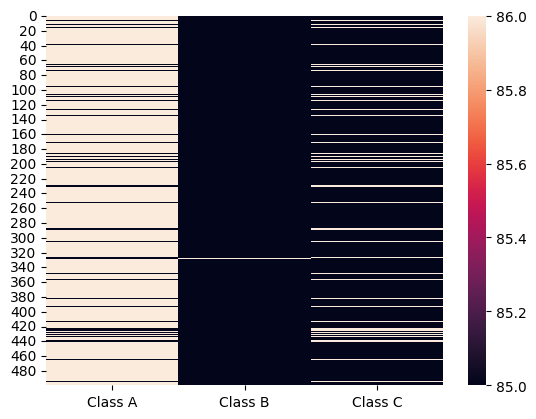

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize a matrix to store the counts
class_counts = np.zeros((500, 3))

for epoch in range(500):
    for batch_idx, (data, labels) in enumerate(train_loader):
        # Count the number of examples in each class
        class_counts[epoch, 0] = np.sum(labels == 0)
        class_counts[epoch, 1] = np.sum(labels == 1)
        class_counts[epoch, 2] = np.sum(labels == 2)
    
# Convert the counts to a DataFrame
df_class_counts = pd.DataFrame(class_counts, columns=['Class A', 'Class B', 'Class C'])

# Plot the heatmap
sns.heatmap(df_class_counts)
plt.show()

What if we tried to again predict the peak shaving, and check for different predicates what is their satisfaction level.
- it would make sense that if we have a predicate: SOC <= 20 stop peak shaving, than if the treshold is good (or the rule in general), than the satisfaction of this rule will be high.
- This could also allow us to check the relation to the solar panels ? -> if the predicat that includes it does better than that that does not include it


In [77]:
def check_peak_shaving(row):
    if row['GARAGE_EXTERNAL_POWER'] >= row['DEMAND_LIMIT']:
        return True
    else:
        return False

s_data['Peak_Shaving'] = s_data.apply(check_peak_shaving, axis=1)


In [78]:
# Define the thresholds
battery_discharge_power_threshold = 0
pv_power_threshold = 0.5

def adjust_peak_shaving(row):
    if row['Peak_Shaving'] == True:
        if row['BATTERY_DISCHARGE_POWER'] > battery_discharge_power_threshold or row['PV_POWER'] > pv_power_threshold:
            return True
        else:
            return False
    else:
        return False



In [79]:
s_data['Peak_Shaving'] = s_data.apply(adjust_peak_shaving, axis=1)

In [88]:
s_data

,_time,GARAGE_EXTERNAL_POWER,DEMAND_LIMIT,BATTERY_SOC,BATTERY_DISCHARGE_POWER,BATTERY_CHARGED_ENERGY,BATTERY_DISCHARGED_ENERGY,PV_POWER,PV_ENERGY,Peak_Shaving
0,2023-10-05 00:01:00+00:00,1.244171,50.0,40.5,-0.338,0.0,0.0,0.008693,0.000000,False
1,2023-10-05 00:02:00+00:00,1.244171,50.0,40.5,-0.372,0.0,0.0,0.008693,0.000000,False
2,2023-10-05 00:03:00+00:00,1.244171,50.0,40.5,-0.393,0.0,0.0,0.008693,0.000000,False
3,2023-10-05 00:04:00+00:00,1.244171,50.0,40.5,-0.339,0.0,0.0,0.008693,0.000000,False
4,2023-10-05 00:05:00+00:00,1.244171,50.0,40.5,-0.371,0.0,0.0,0.008693,0.000000,False
...,...,...,...,...,...,...,...,...,...,...
59437,2023-11-18 23:55:00+00:00,1.244171,50.0,41.0,-0.380,0.0,0.0,0.007606,0.000000,False
59438,2023-11-18 23:56:00+00:00,1.148468,50.0,41.0,-0.458,0.0,0.0,0.007606,0.000000,False
59439,2023-11-18 23:57:00+00:00,1.244171,50.0,41.0,-0.437,0.0,0.0,0.007705,0.000000,False
59440,2023-11-18 23:58:00+00:00,1.244171,50.0,41.0,-0.476,0.0,0.0,0.007705,0.000000,False


In [99]:
features = s_data.drop(['_time','Peak_Shaving', 'DEMAND_LIMIT', 'BATTERY_DISCHARGE_POWER', 'BATTERY_CHARGED_ENERGY',  'BATTERY_DISCHARGED_ENERGY'], axis=1)
target = s_data['Peak_Shaving']

In [100]:
features

,GARAGE_EXTERNAL_POWER,BATTERY_SOC,PV_POWER,PV_ENERGY
0,1.244171,40.5,0.008693,0.000000
1,1.244171,40.5,0.008693,0.000000
2,1.244171,40.5,0.008693,0.000000
3,1.244171,40.5,0.008693,0.000000
4,1.244171,40.5,0.008693,0.000000
...,...,...,...,...
59437,1.244171,41.0,0.007606,0.000000
59438,1.148468,41.0,0.007606,0.000000
59439,1.244171,41.0,0.007705,0.000000
59440,1.244171,41.0,0.007705,0.000000


In [101]:

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [102]:
features_train = torch.tensor(features_train.to_numpy()).float()
target_train = torch.tensor(target_train.to_numpy()).float()
features_test = torch.tensor(features_test.to_numpy()).float()
target_test = torch.tensor(target_test.to_numpy()).float()

Lets try first with a simple rule 
if GARAGE_EXTERNAL_POWER > DEMAND_LIMIT and SOC >= 15%

In [104]:
import ltn
# we define predicate A
class ModelA(torch.nn.Module):
    def __init__(self):
        super(ModelA, self).__init__()
        self.sigmoid = torch.nn.Sigmoid()
        self.layer1 = torch.nn.Linear(4, 16)  
        self.layer2 = torch.nn.Linear(16, 16)
        self.layer3 = torch.nn.Linear(16, 1)
        self.elu = torch.nn.ELU()

    def forward(self, x):
        x = self.elu(self.layer1(x))
        x = self.elu(self.layer2(x))
        return self.sigmoid(self.layer3(x))


A = ltn.Predicate(ModelA())

And = ltn.Connective(ltn.fuzzy_ops.AndProd())
Not = ltn.Connective(ltn.fuzzy_ops.NotStandard())
Implies = ltn.Connective(ltn.fuzzy_ops.ImpliesReichenbach())
Exists = ltn.Quantifier(ltn.fuzzy_ops.AggregPMean(p=2), quantifier="e")
Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")
SatAgg = ltn.fuzzy_ops.SatAgg()

In [105]:
from sklearn.metrics import accuracy_score
import numpy as np

# this is a standard PyTorch DataLoader to load the dataset for the training and testing of the model
class DataLoader(object):
    def __init__(self,
                 data,
                 labels,
                 batch_size=1,
                 shuffle=True):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.unique_labels = np.unique(labels) 

    def __len__(self):
        return int(np.ceil(self.data.shape[0] / self.batch_size))

    def __iter__(self):
        # Create a list of indices for each class
        indices_per_class = {label: np.where(self.labels == label)[0] for label in self.unique_labels}

        # Calculate the number of samples per class in each batch
        samples_per_class = max(1, self.batch_size // len(self.unique_labels))

        for _ in range(len(self)):
            batch_indices = []

            for label in self.unique_labels:
                # Randomly sample indices for this class
                class_indices = np.random.choice(indices_per_class[label], size=samples_per_class, replace=True)
                batch_indices.extend(class_indices)

            # If the batch size is not a multiple of the number of classes, fill the rest of the batch randomly
            if len(batch_indices) < self.batch_size:
                extra_indices = np.random.choice(np.arange(len(self.labels)), size=self.batch_size - len(batch_indices))
                batch_indices.extend(extra_indices)

            if self.shuffle:
                np.random.shuffle(batch_indices)

            yield self.data[batch_indices], self.labels[batch_indices]


# define metrics for evaluation of the model

# it computes the overall satisfaction level on the knowledge base using the given data loader (train or test)
def compute_sat_level(loader):
    mean_sat = 0
    for data, labels in loader:
        x_A = ltn.Variable("x_A", data[torch.nonzero(labels)])  # positive examples
        x_not_A = ltn.Variable("x_not_A",
                               data[torch.nonzero(torch.logical_not(labels))])  # negative examples
        mean_sat += SatAgg(
            Forall(x_A, A(x_A)),
            Forall(x_not_A, Not(A(x_not_A)))
        )
    mean_sat /= len(loader)
    return mean_sat

# it computes the overall accuracy of the predictions of the trained model using the given data loader
# (train or test)
def compute_accuracy(loader):
    mean_accuracy = 0.0
    for data, labels in loader:
        predictions = A.model(data).detach().numpy()
        predictions = np.where(predictions > 0.5, 1., 0.).flatten()
        mean_accuracy += accuracy_score(labels, predictions)

    return mean_accuracy / len(loader)

# create train and test loader, 50 points each
# batch size is 64, meaning there is only one batch for epoch
train_loader = DataLoader(features_train, target_train, 256, True)
test_loader = DataLoader(features_test, target_test, 256, False)

In [106]:
# # def P(tensor):
# #     print(tensor)
# #     external_power, demand_limit, soc = tensor
# #     return (external_power > demand_limit) & (soc >= 15)
# def P(tensor):
#     # print(tensor)
#     external_power, soc = tensor.t()  # transpose the tensor
#     return external_power > 50
#     # return (external_power < demand_limit)
#     # return (external_power > demand_limit) & (soc >= 15)

# # Wrap the predicate in an LTN Predicate
# P = ltn.Predicate(None, P)

In [107]:
# def Q(tensor):
#     return tensor >= 0.5  # returns True if p_shav is True

# # Wrap the predicate in an LTN Predicate
# Q = ltn.Predicate(None, Q)

In [128]:
# soc_tensor = torch.tensor(s_data['BATTERY_SOC'].values, dtype=torch.float32)
# external_power_tensor = torch.tensor(s_data['GARAGE_EXTERNAL_POWER'].values, dtype=torch.float32)
# p_shav = torch.tensor(s_data['Peak_Shaving'].values, dtype=torch.float32)


# def phi(external_power_tensor, soc_tensor, p_shav):
#     # Stack the tensors along the last dimension to create a single tensor
#     data = torch.stack([external_power_tensor, soc_tensor], dim=-1)

#     # Create a variable that represents the data
#     p = ltn.Variable("p", data)
#     q = ltn.Variable("q", p_shav)

#     # Return the satisfaction degree of the formula
#     return Forall(p, Implies(P(p), Q(q))).value

In [ ]:
optimizer = torch.optim.Adam(A.parameters(), lr=0.001)

# training of the predicate A using a loss containing the satisfaction level of the knowledge base
# the objective it to maximize the satisfaction level of the knowledge base
for epoch in range(500):
    train_loss = 0.0
    for batch_idx, (data, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        # we ground the variables with current batch data
        x_A = ltn.Variable("x_A", data[labels==1]) # positive examples
        x_not_A = ltn.Variable("x_not_A", data[labels==0]) # negative examples
        sat_agg = SatAgg(
            Forall(x_A, A(x_A)),
            Forall(x_not_A, Not(A(x_not_A)))
        )
        loss = 1. - sat_agg
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss = train_loss / len(train_loader)

    # we print metrics every 20 epochs of training
    if epoch % 1 == 0:
        print(" epoch %d | loss %.4f | Train Sat %.3f | Test Sat %.3f | Train Acc %.3f | Test Acc %.3f"
              %(epoch, train_loss, compute_sat_level(train_loader), compute_sat_level(test_loader),
                    compute_accuracy(train_loader), compute_accuracy(test_loader)))

In [109]:
features

,GARAGE_EXTERNAL_POWER,BATTERY_SOC,PV_POWER,PV_ENERGY
0,1.244171,40.5,0.008693,0.000000
1,1.244171,40.5,0.008693,0.000000
2,1.244171,40.5,0.008693,0.000000
3,1.244171,40.5,0.008693,0.000000
4,1.244171,40.5,0.008693,0.000000
...,...,...,...,...
59437,1.244171,41.0,0.007606,0.000000
59438,1.148468,41.0,0.007606,0.000000
59439,1.244171,41.0,0.007705,0.000000
59440,1.244171,41.0,0.007705,0.000000


In [131]:
optimizer = torch.optim.Adam(A.parameters(), lr=0.001)

# training of the predicate A using a loss containing the satisfaction level of the knowledge base
# the objective it to maximize the satisfaction level of the knowledge base
for epoch in range(500):
    train_loss = 0.0
    for batch_idx, (data, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        # we ground the variables with current batch data
        x_A = ltn.Variable("x_A", data[labels==1]) # positive examples
        x_not_A = ltn.Variable("x_not_A", data[labels==0]) # negative examples
        # print(data)
        external_power_tensor, soc_tensor, _,_ = data.t()
        p_shav = labels
        sat_agg = SatAgg(
            Forall(x_A, A(x_A)),
            Forall(x_not_A, Not(A(x_not_A))),
            # phi(external_power_tensor, soc_tensor, p_shav)  # include phi in the satisfaction aggregation
        )
        loss = 1. - sat_agg
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss = train_loss / len(train_loader)

    # we print metrics every 20 epochs of training
    if epoch % 20 == 0:
        print(" epoch %d | loss %.4f | Train Sat %.3f | Test Sat %.3f | Train Acc %.3f | Test Acc %.3f"# | Phi Sat %.3f"
              %(epoch, train_loss, compute_sat_level(train_loader), compute_sat_level(test_loader),
                    compute_accuracy(train_loader), compute_accuracy(test_loader) ))#, phi(external_power_tensor, soc_tensor, p_shav)))

 epoch 0 | loss 0.2672 | Train Sat 0.733 | Test Sat 0.735 | Train Acc 0.914 | Test Acc 0.915


KeyboardInterrupt: 